In [18]:
from time import time
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import physical_constants
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm

from ries.constituents.isotope import Isotope
from ries.constituents.state import GroundState, State
from ries.constituents.element import natural_elements
from ries.resonance.voigt import Voigt

# Application of Bayesian Statistics to a Self-Absorption Experiment

This notebook demonstrates the use of the `ries` library to analyze experimental data.
The goal is to obtain a posterior distribution (uncertainty, 'error') for the value of a nuclear property from a set of observables with prior distributions.

As an example, a self-absorption measurement of the width $\Gamma_\gamma$ (also denoted as $\Gamma$ below) of the first excited $0^+$ state of the nucleus $^6$Li [1] is reanalyzed here.
All information used here can be found in the aforementioned reference and the associated supplemental material.
It should also be pointed out again here that the formalism is covered in detail in the dissertation of C. Romig [2].
In fact, the planning, executation, and preliminary analysis of the $^6$Li experiment was about one half of C. Romig's thesis work.

To approximate the posterior distribution for $\Gamma_\gamma$, the 'Propagation of distributions using a Monte Carlo' suggested in the Guide to the expression of uncertainty in measurement (GUM) [3] is used.

[1] U. Friman-Gayer *et al.*, Phys. Rev. Lett. **126**, 102501 (2021) https://doi.org/10.1103/PhysRevLett.126.102501; arXiv:2005.07837 https://arxiv.org/abs/2005.07837

[2] C. Romig, Investigation of Nuclear Structure with Relative Self-Absorption Measurements, Dissertation, TU Darmstadt (2015) (https://tuprints.ulb.tu-darmstadt.de/id/eprint/4446)

[3] Bureau International des Poids et Mesures (BIPM), Evaluation of measurement data - Supplement 1 to the "Guide to the expression of uncertainty in measurement" - Propagation of distributions using a Monte Carlo method, JCGM 102:2008 (2008) (https://www.bipm.org/utils/common/documents/jcgm/JCGM_101_2008_E.pdf)

## Definitions

Define properties of the target and the nucleus.
The total width and input properties like the effective temperature are initialized with their most probable values from Ref. [1].

In [19]:
li6 = Isotope("6Li",
        natural_elements["Li"].isotopes["6Li"].amu,
        ground_state=GroundState("1^+_1", two_J=2, parity=1),
        excited_states={
            "0^+_1": State(
                "0^+_1", two_J=0, parity=1, 
                excitation_energy=3.56288,
                partial_widths={"1^+_1": 8.17e-6}
            )
        }
       )

sigma = Voigt(
    initial_state=li6.ground_state,
    intermediate_state=li6.excited_states['0^+_1'],
    amu=li6.amu,
    effective_temperature=411.,
)

Define all input quantities that have a non-negligible uncertainty.
Their probability density functions (PDFs) are assumed to be normal distributions.
The experiment on $^6$Li was termed a precision measurement, since all of the relative uncertainties are smaller than a few percent.

Probably, a first-order approximation for the propagation of uncertainty ('Gaussian propagration of uncertainty') would give similar results to the Bayesian method employed here.
However, since the relation between $\Gamma_\gamma$ and the input quantities features an integral, the derivation might be a bit more involved, while the Monte Carlo method needs nothing more than the definition of $R$.
In addition, one gets all the other advantages of Bayesian methods like a correct treatment of correlations and, in principle, all moments of the posterior distribution.
Of course, the Monte Carlo method requires a lot more computing power.

To be able to draw random samples for each input quantity, they are implemented as random variables using the `scipy.rv_continuous` class.

In [20]:
li6_enrichment = norm(0.9500, 0.0001) # Enrichment of the 6Li material (Ratio of the number of 6Li nuclei versus the total number of lithium nuclei), which is used in the scatterer and the absorber.
target_diameter = norm(0.01900, 0.00005) # Diameter of all targets in m. Reference [1] falsely gives the outer instead of the inner diameter of the target container, but the areal densities are correct.
li6_scatterer_mass = norm(5.033e-3, 0.005e-3) # Mass of the scatter in kg
li6_absorber_mass = norm(9.938e-3, 0.005e-3) # Mass of the absorber in kg

For simplicity, use the normal-distributed value of the relative self absorption as it is given in [1].
Actually, this is already a derived quantity, because it is composed of the total number of counts with ($N_\mathrm{RSA}$) and without ($N_\mathrm{NRF}$) the absorber target and the correction factor $f$ (which is a derived quantity as well).
All of three parameters were assumed to follow a normal distribution with a sufficiently small standard deviation to apply first-order propagation of uncertainty.

In [21]:
R_exp = norm(0.5192, 0.0020)

Define some helpful functions, in particular the photon flux density $\Phi$ and the resonance absorption density $\alpha$.
Compared to other notebooks in the `ries` library, the expressions for $\Phi$ and $\alpha$ are very simple here, because the impact of all other target layers ($^{11}$B monitor targets)  and the nonresonant absorption in the $^6$Li targets themselves is taken into account by the $f$ factor.

The functions take the input parameters specified above as arguments.

In [22]:
def molar_mass(enrichment):
    """Calculate the molar mass of lithium carbonate in dependence of the 6Li enrichment
    
Parameters
----------
enrichment: float
    Ratio of the number of 6Li nuclei versus the total number of lithium nuclei (6Li and 7Li)
    
Returns
-------
float
    Molar mass in atomic mass units.
"""
    return (
        2.*(
            li6_enrichment.mean()*li6.amu
            +(1.-li6_enrichment.mean())
            *natural_elements["Li"].isotopes["7Li"].amu
        ) # Li_2
        +natural_elements["C"].amu # C
        +3.*natural_elements["O"].amu # O_3
    )

def areal_density(mass, diameter, enrichment):
    """Calculate the areal density of a cylindrical, 6Li-enriched, lithium carbonate sample
    
Parameters
----------
mass: float
    Sample mass in kg.
diameter: float
    Sample diameter in m.
enrichment: float
    Ratio of the number of 6Li nuclei versus the total number of Lithium nuclei (6Li and 7Li).
    
Returns
-------
float
    Areal density in fm^2.
"""
    return (
        2.*enrichment*mass
        /(
            molar_mass(enrichment)
            *physical_constants["atomic mass constant"][0]
            *np.pi*(0.5*diameter*1e15)**2)
        )

def photon_flux_density(sigma, energy, rho):
    """Photon-flux density
    
Parameters
----------
sigma: Resonance object
    Resonance cross section.
energy: float
    Photon energy in MeV.
rho: float
    Areal density in fm^2.
    
Returns
-------
float
    Dimensionless photon-flux density.
"""
    return np.exp(-sigma(energy, input_is_absolute_energy=False)*rho)

def resonance_absorption_density(sigma, energy, rho):
    """Resonance-absorption density
    
Parameters
----------
sigma: Resonance object
    Resonance cross section.
energy: float
    Photon energy in MeV.
rho: float
    Areal density in fm^2.
    
Returns
-------
float
    Resonance-absorption density in fm^2.
"""
    return sigma(energy, input_is_absolute_energy=False)*photon_flux_density(sigma, energy, rho)

## Plots

Plot the energy dependence of the resonance cross section.
Compared to most other purely electromagnetic transitions of atomic nuclei, the width of the $1^+ \rightarrow 0^+$ transition of $^6$Li is extremely large.
It is so large that the cross section retains its Breit-Wigner form (Cauchy distribution), even though the Doppler broadening effect is strong for light atoms like lithium.

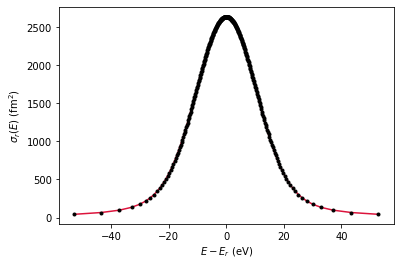

In [23]:
_energies_plot = sigma.equidistant_probability_grid(0.97, 301)-sigma.intermediate_state.excitation_energy
_energies_plot_eV = _energies_plot*1e6
_sigma_plot = sigma(_energies_plot, input_is_absolute_energy=False)

fig, ax = plt.subplots(1,1)
ax.set_xlabel(r"$E - E_r$ (eV)")
ax.set_ylabel(r"$\sigma_r(E)$ (fm$^2$)")
ax.plot(_energies_plot_eV, _sigma_plot, "-", color="crimson")
ax.plot(_energies_plot_eV, _sigma_plot, ".", color="black")

Plot the photon flux density $\Phi_a$ for the absorber.
The $^6$Li experiment was configured for an optimum self-absorption effect of $R_\mathrm{exp} \approx 0.5$, so the shapes of this one and the following plots are somewhat universal for efficient self-absorption effects.

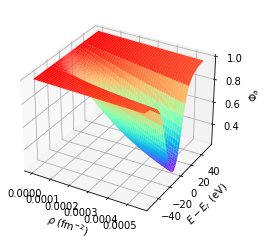

In [24]:
_rho_abs_plot_1d = np.linspace(
    0., areal_density(
        li6_absorber_mass.mean(),
        target_diameter.mean(), li6_enrichment.mean())
)
_rho_abs_plot_2d, _energies_plot_2d = np.meshgrid(
    _rho_abs_plot_1d, _energies_plot
)
_phi_abs_plot = photon_flux_density(
    sigma, _energies_plot_2d, _rho_abs_plot_2d
)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel(r"$\rho$ (fm$^{-2}$)")
ax.set_ylabel(r"$E - E_r$ (eV)")
ax.set_zlabel(r"$\Phi_a$")
ax.plot_surface(
    _rho_abs_plot_2d,
    _energies_plot_2d*1e6,
    _phi_abs_plot,
    cmap="rainbow"
)

Plot the resonance absorption density for the scatterer.

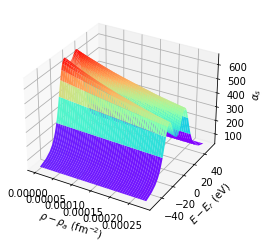

In [25]:
_rho_sca_plot_1d = np.linspace(
    0., areal_density(
        li6_scatterer_mass.mean(),
        target_diameter.mean(), li6_enrichment.mean()
    )
)
_rho_sca_plot_2d, _energies_plot_2d = np.meshgrid(
    _rho_sca_plot_1d, _energies_plot
)
_alpha_sca_plot = (
    photon_flux_density(sigma, _energies_plot_2d, areal_density(
        li6_absorber_mass.mean(),
        target_diameter.mean(), li6_enrichment.mean()))
    *resonance_absorption_density(
        sigma, _energies_plot_2d, _rho_sca_plot_2d
    )
)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel(r"$\rho - \rho_a$ (fm$^{-2}$)")
ax.set_ylabel(r"$E - E_r$ (eV)")
ax.set_zlabel(r"$\alpha_s$")
ax.plot_surface(
    _rho_sca_plot_2d,
    _energies_plot_2d*1e6,
    _alpha_sca_plot,
    cmap="rainbow"
)

## Definition of the Self Absorption

Define a function that returns the self absorption in depedence on all the input parameters defined above.
It utilizes the helper classes/functions from `ries.constituents`, `ries.resonance`, and above.

The calculation of $R$, as derived in the supplemental material of Ref. [1], contains two-dimensional integrations of the resonance absorption density over the energy and the areal density of the form:

$\int_0^\infty \int_0^{\rho_s} \sigma_r \left( E \right) \Phi \left( E, \rho^\prime \right) \exp \left[ -\sigma_r \left( E\right) \rho \right] \mathrm{d} E \mathrm{d} \rho$

The demand on `scipy`'s numerical integration can be strongly reduced by solving the areal-density integral analytically, which leaves a one-dimensional integral of the form:

$\int_0^\infty \Phi \left( E, \rho^\prime \right) \left\{ 1 - \exp \left[ -\sigma_r \left( E\right) \rho \right] \right\} \mathrm{d} E$

The (numerical) energy integration is performed within a finite energy interval returned by the `resonance.coverage_interval` function.
If a coverage too close to 1 is chosen, the interval may become so large that the integration algorithm cannot find the peak any more.

In [26]:
def R(Gamma, absorber_mass, scatterer_mass,
      diameter, enrichment, effective_temperature,
      energy_coverage_interval=0.999):
    """Calculate the self absorption for the 6Li experiment in dependence on the input parameters
    
Parameters
----------
Gamma: float
    Total width of the first excited 0^+ state of 6Li in MeV.
absorber_mass, scatterer_mass: float
    Absorber/scatterer mass in kg.
diameter: float
    Sample diameter in m.
enrichment: float
    Ratio of the number of 6Li nuclei versus the total number of Lithium nuclei (6Li and 7Li).
effective temperature: float
    Effective temperature of lithium carbonate in K.
energy_coverage_interval: float
    The numerical integration will use a symmetric coverage interval around the resonance peak
with the given coverage.

Returns
-------
float
    Experimental self absorption R.
    """
    li6 = Isotope("6Li",
            natural_elements["Li"].isotopes["6Li"].amu,
            ground_state=GroundState("1^+_1", two_J=2, parity=1),
            excited_states={
                "0^+_1": State(
                    "0^+_1", two_J=0, parity=1, 
                    excitation_energy=3.56288,
                    partial_widths={"1^+_1": Gamma}
                )
            }
           )

    sigma = Voigt(
        initial_state=GroundState("1^+_1", two_J=2, parity=1),
        intermediate_state=State(
            "0^+_1", two_J=0, parity=1, 
            excitation_energy=3.56288,
            partial_widths={"1^+_1": Gamma}
        ),
        amu=natural_elements["Li"].isotopes["6Li"].amu,
        effective_temperature=effective_temperature,
    )
    
    absorber_areal_density = areal_density(
        absorber_mass,
        diameter, enrichment
    )
    scatterer_areal_density = areal_density(
        scatterer_mass,
        diameter, enrichment
    )
    
    energy_limits = sigma.coverage_interval(energy_coverage_interval) - sigma.intermediate_state.excitation_energy
    
    return (
        1.-quad(
            lambda energy: 
            (
                photon_flux_density(sigma, energy, absorber_areal_density)
                *(1.-np.exp(-sigma(energy, input_is_absolute_energy=False)*scatterer_areal_density))
            ),
            *energy_limits
        )[0]
        /quad(
            lambda energy: 
            (
                (1.-np.exp(-sigma(energy, input_is_absolute_energy=False)*scatterer_areal_density))
            ),
            *energy_limits
        )[0]
    )

## Numerical Evaluation

In order to approximate the posterior PDF for $\Gamma$, $n$ random values from the PDFs of the input quantities are sampled in a Monte Carlo procedure.
This requires to have an expression of the type:

$\Gamma = \Gamma \left( R, \left\{ p \right\} \right)$,

i.e. the transition width as a function of the self absorption $R$ and a set of other input parameters $\left\{ p \right\}$.
In the case of the first exctied $0^+$ state of $^6$Li, the relation between $\Gamma$ and $R$ is strictly monotonous, but it is not possible to invert the function $R \left( \Gamma, \left\{ p \right\} \right)$ analytically.
For this reason, the value $\Gamma_r$ that corresponds corresponds to given random samples $R_r$ and $\left\{ p_r \right\}$ is obtained from a minimization procedure:

$\Gamma_r = \mathrm{min}_\Gamma \left| R\left( \Gamma, \left\{ p_r \right\} \right) - R_r \right|$

It was found that the "Nelder-Mead" method of `scipy.optimize.minimize` performs better than gradient-based methods in the present case, but some fine tuning of the tolerance is required to achieve a sufficiently high precision.
The code below checks whether an 'inversion by minimization' was successful by calculating:

$R_r = R \left( \Gamma_r, \left\{ p_r \right\} \right)$

In [ ]:
n_random = 1000 # Number of random samples
R_exp_tolerance = 1e-4 # Determines the absolute tolerance of the numerical inversion. If this is not achieved, a warning message is printed.

update_percentage = 0.01 # Prints progress updates whenever the fraction of processed samples has increased by this amount.
current_percentage = 0.


Gamma_values = [] # Store the random samples for Gamma
R_exp_values = [] # Stores the random samples for R_exp

t_start = time()
for n in range(n_random):
    # Print progress
    if n/n_random > current_percentage + update_percentage:
        current_percentage = current_percentage + update_percentage
        print('{:5.2f} % processed, {:4d} seconds.'.format(current_percentage*100., int(time()-t_start)))
    
    # Sample random values
    li6_absorber_mass_random = li6_absorber_mass.rvs()
    li6_scatterer_mass_random = li6_scatterer_mass.rvs()
    target_diameter_random = target_diameter.rvs()
    li6_enrichment_random = li6_enrichment.rvs()
    R_exp_values.append(R_exp.rvs())

    # Invert R(Gamma) by numerical minimization
    Gamma_values.append(
        minimize(
            lambda Gamma: abs(
                R(
                    Gamma=Gamma,
                    absorber_mass=li6_absorber_mass_random,
                    scatterer_mass=li6_scatterer_mass_random, 
                    diameter=target_diameter_random,
                    enrichment=li6_enrichment_random,
                    effective_temperature=411.,
                )
                -R_exp_values[n]
            ),
            x0=8.17e-6, # Choose the result from Ref. [1] as start value.
            method="Nelder-Mead",
            tol=0.1*R_exp_tolerance,
        ).x[0]
    )

    # Check whether the inversion was successful. If not, print a warning message.
    R_exp_test = R(
                    Gamma=Gamma_values[n],
                    absorber_mass=li6_absorber_mass_random,
                    scatterer_mass=li6_scatterer_mass_random, 
                    diameter=target_diameter_random,
                    enrichment=li6_enrichment_random,
                    effective_temperature=411.,
                )
    
    if not np.isclose(R_exp_test, R_exp_values[n], atol=R_exp_tolerance):
        warn("Γ({:e}) = {:e}, but R(Γ) = {:e}".format(R_exp_values[n], Gamma_values[n], R_exp_test))

Plot the approximated (unnormalized) posterior PDF for the total width and evaluate the mean and the standard deviation of the Monte Carlo samples.

Gamma = 8.10 +- 0.15 eV


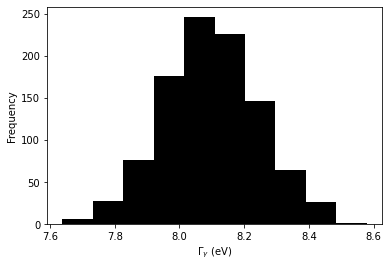

In [17]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("$\Gamma_\gamma$ (eV)")
ax.set_ylabel("Frequency")
ax.hist(np.array(Gamma_values)*1e6, color='black')

print("Gamma = {:4.2f} +- {:4.2f} eV".format(np.mean(Gamma_values)*1e6, np.std(Gamma_values)*1e6))